# Building Input Pipeline for train and test data

In [55]:
import numpy as np 
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
import xml.dom.minidom
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D

Populating the interactive namespace from numpy and matplotlib


In [ ]:
#source :- https://www.tensorflow.org/api_docs/python/tf/data/Dataset

height , width = 1024 , 1024 #size to which input image needs to resize

def mapping(file_path):

  table_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_table')
  column_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_column')

  table_path = tf.strings.regex_replace(table_path, '.jpeg', '.bmp_table.jpeg')
  column_path = tf.strings.regex_replace(column_path, '.jpeg', '.bmp_col.jpeg')
  

  #reading  , resizing and normalizing for image data
  images = tf.io.read_file(file_path)
  images = tf.image.decode_jpeg(images, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
  images = tf.cast(images, tf.float32) / 255.0 # normalizing image

  #reading  , resizing and normalizing for table mask data
  table_mask = tf.io.read_file(table_path)
  table_mask = tf.image.decode_jpeg(table_mask, channels=1) 
  table_mask = tf.image.resize(table_mask, [height, width]) #resizing image to input shape of model
  table_mask = tf.cast(table_mask, tf.float32) / 255.0 

  #reading  , resizing and normalizing for column mask data
  column_mask = tf.io.read_file(column_path)
  column_mask = tf.image.decode_jpeg(column_mask, channels=1) 
  column_mask = tf.image.resize(column_mask, [height, width]) 
  column_mask = tf.cast(column_mask, tf.float32) / 255.0 

  return images, {"table_mask" : table_mask, "column_mask" : column_mask }

def data_pipeline(dataset, input , batch_size = 1):
  #how many parallel call need to be done , so left tensor to decide
  autotune = tf.data.experimental.AUTOTUNE

  if input == 'train':
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train 
    proportion = 0.9
    input_data_size = int(proportion * total_size)
    
    #fetching data for input
    input_data = dataset.take(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    train_data = input_data

    #kepping track of inital loaded data in the memory to speed up the the process for next iteration 
    input_data = input_data.cache()

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size # randomly samples elements from this buffer, replacing the selected elements with new elements
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    # to re-initialize the input_data
    input_data = input_data.repeat()

    #delivers data for the next step before the current step has finished
    input_data = input_data.prefetch(buffer_size=autotune)

    return input_data , train_data

  else:
    #length of file list
    total_size = len(list(dataset))

    #proportion of file to be fetched for train and test
    proportion = 0.9
    input_data_size = int(proportion * total_size)
    
    #fetching data for input
    input_data = dataset.skip(input_data_size)
    
    #mapping file from input data
    input_data = input_data.map(mapping,num_parallel_calls=autotune)
    test_data = input_data

    #Randomly shuffles the elements for the given dataset
    buffer_size =  input_data_size 
    input_data = input_data.shuffle(buffer_size)

    #creating input file in batch 
    input_data = input_data.batch(batch_size)

    return input_data , test_data


In [ ]:
#Create a source dataset from given  input data
#dataset = tf.data.Dataset.list_files("/content/content/Shareddrives/my_drive/input/CHK1/data/marmots_1024/*.jpeg")
dataset = tf.data.Dataset.list_files("/content/content/MyDrive/table_extraction/marmots_usuals/*.jpeg")

train_dataloader , train_data = data_pipeline(dataset, 'train' , batch_size = 1)
test_dataloader , test_data= data_pipeline(dataset, 'test' , batch_size = 1)

# **Applying AlexNet from scratch**

In [9]:
X_input = Input((256,256,3))

#1st Convolutional Layer
X = Conv2D(filters=96, input_shape=(32,32,3), kernel_size=(11,11), strides=(4,4), padding='same')(X_input)
X = BatchNormalization()(X)
X = Activation('relu')(X)
maxpool_1 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same')(X)

#2nd Convolutional Layer
X = Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same')(maxpool_1)
X = BatchNormalization()(X)
X = Activation('relu')(X)
maxpool_2 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same' , name = 'maxpool_2')(X)

#3rd Convolutional Layer
X = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same')(maxpool_2)
X = BatchNormalization()(X)
X = Activation('relu')(X)

#4th Convolutional Layer
X = Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

#5th Convolutional Layer
X = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)
maxpool_3 = MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same',name = 'maxpool_3')(X)

#addding 2 (1 * 1) convolutional layers followed by dropot eith 80%
#X = Conv2D(256, (1, 1), activation = 'relu', name='block6_conv1')(AlexNet.output)
X = Conv2D(256, (1, 1), activation = 'relu', name='block6_conv1')(maxpool_3)
X = Dropout(0.8, name='block6_dropout1')(X)
X = Conv2D(256, (1, 1), activation = 'relu', name='block6_conv2')(X)
X = Dropout(0.8, name = 'block6_dropout2')(X)

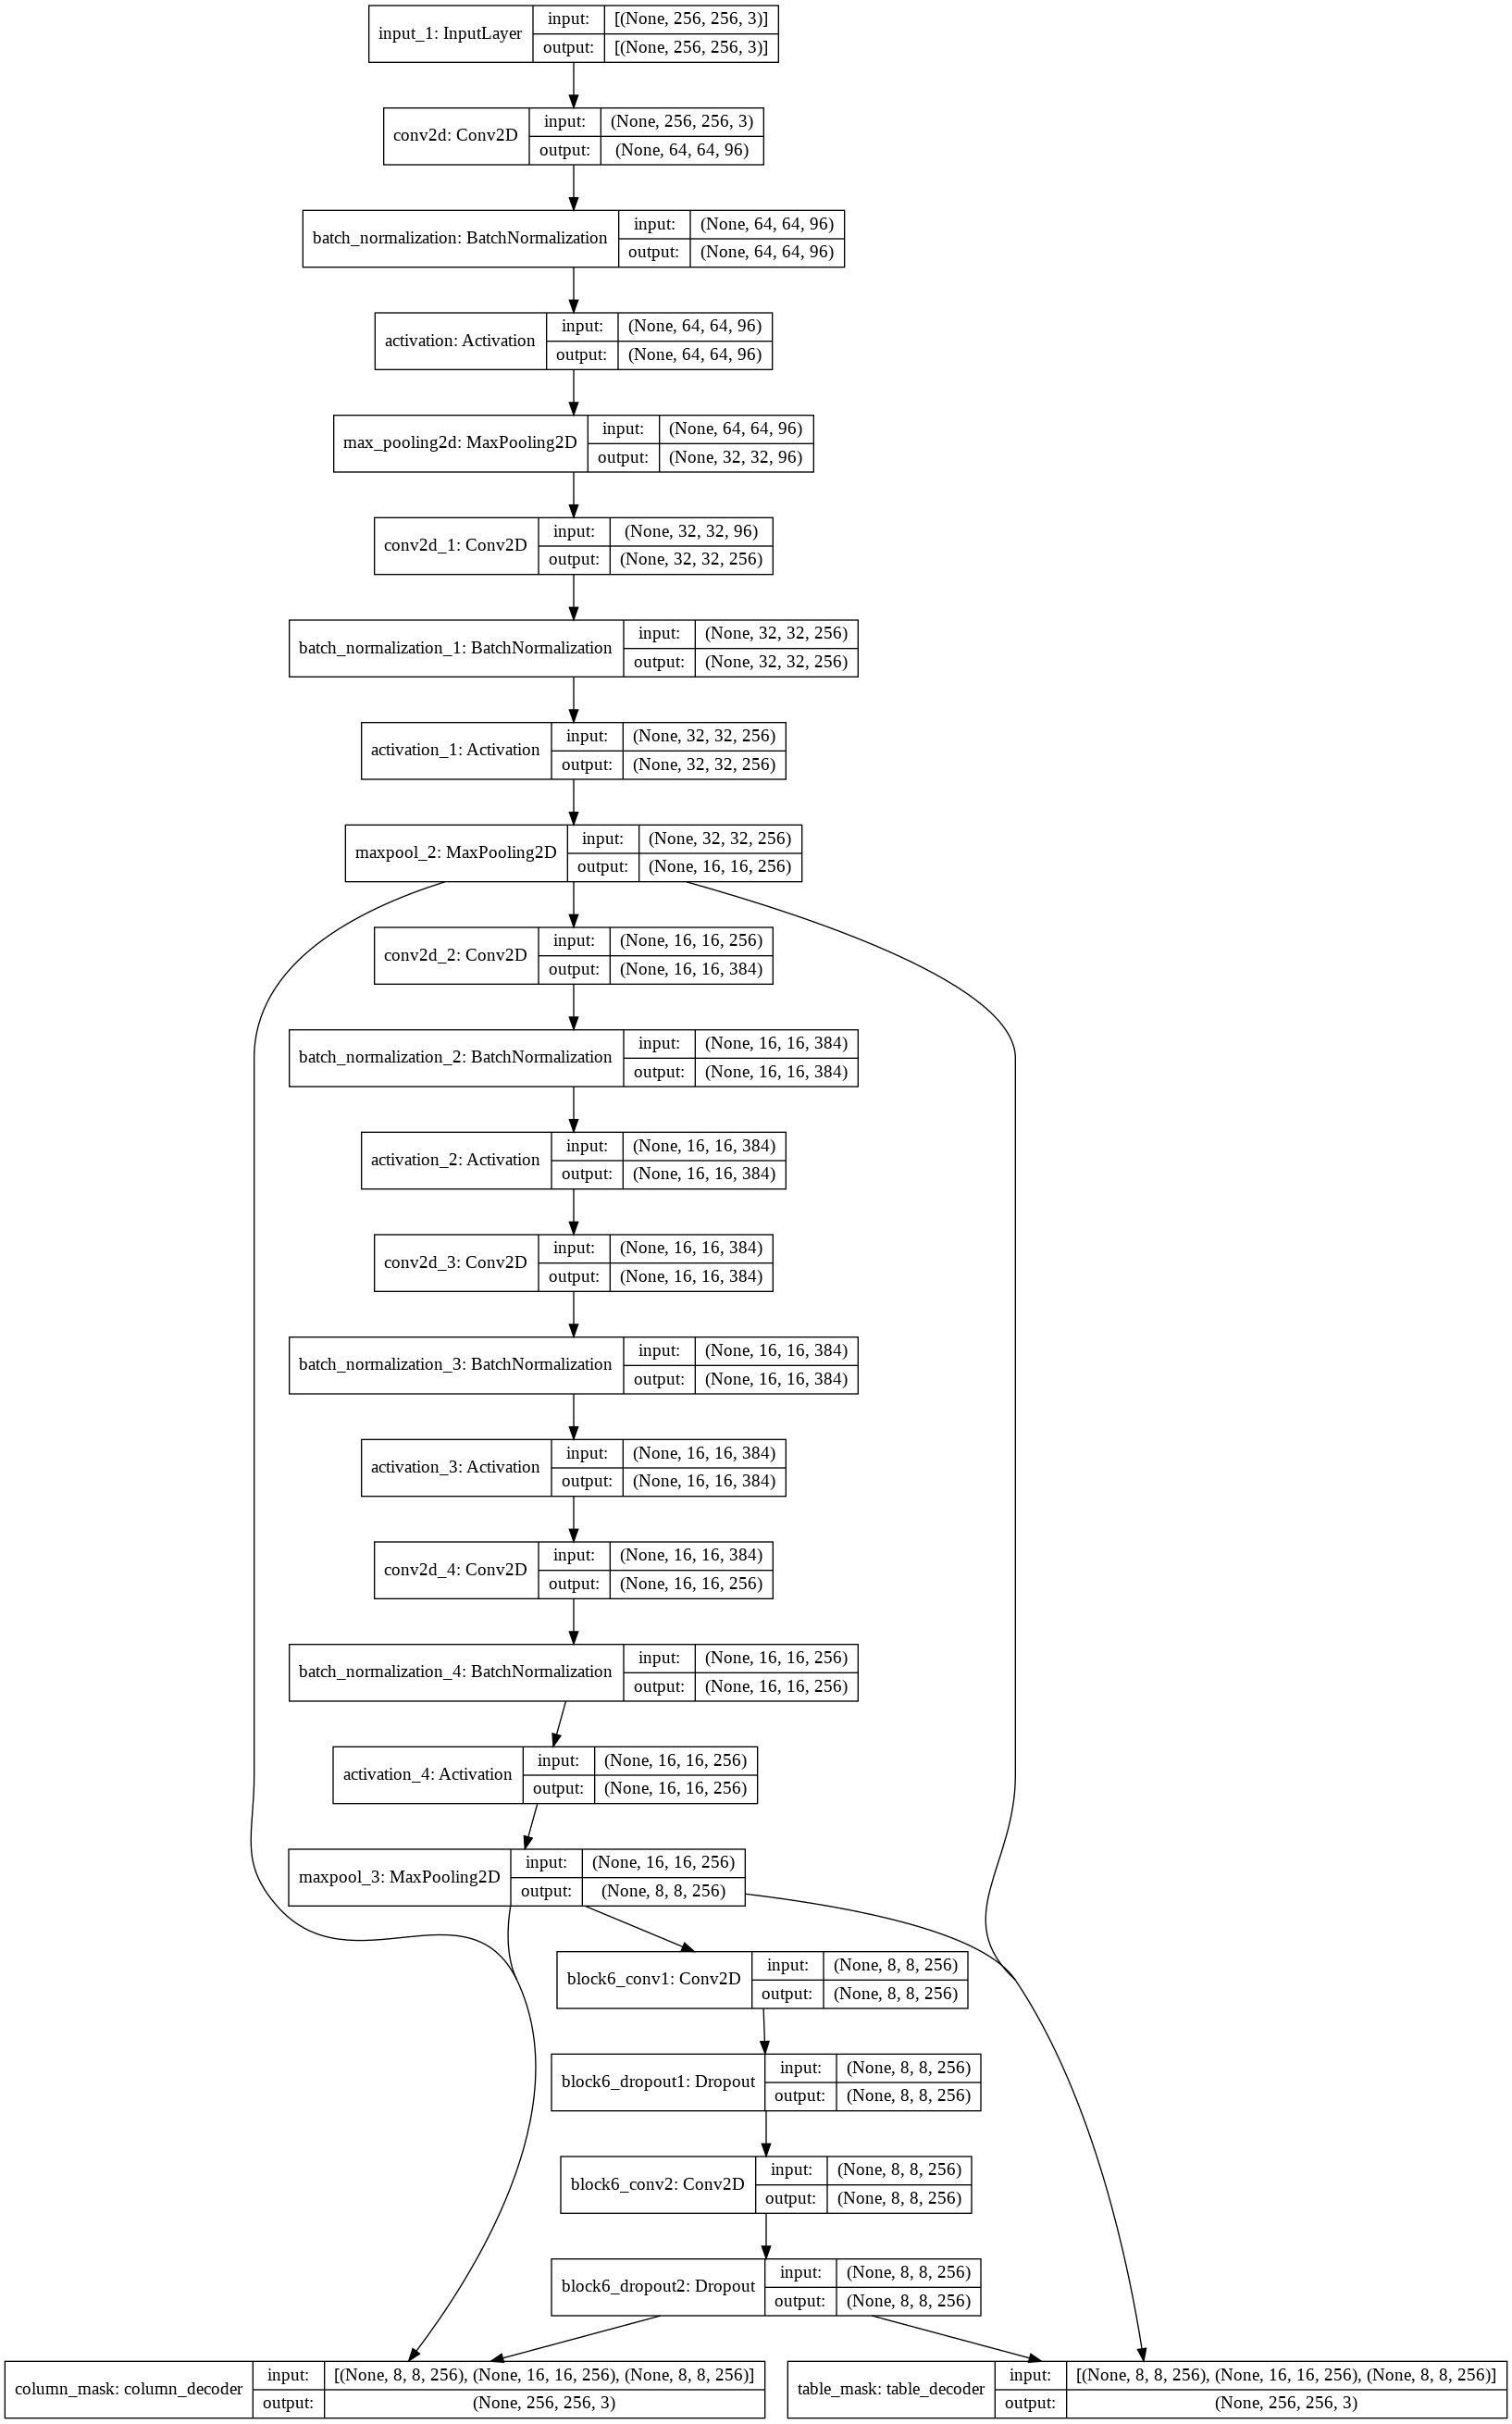

In [10]:
class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name="table_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =256,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(1, 1))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.upsample5 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same')

        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]


      result = self.conv1(input)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.upsample5(result)
      result = self.convtraspose(result)

      return result


class column_decoder(tf.keras.layers.Layer):
    def __init__(self, name="column_mask"):
        super().__init__(name=name)
        self.conv1 = Conv2D(filters =256,kernel_size = (1, 1), activation = 'relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters =256,kernel_size = (1, 1), activation = 'relu')
        self.upsample1 = UpSampling2D(size=(1, 1))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2,2))
        self.upsample4 = UpSampling2D(size=(2,2))
        self.upsample5 = UpSampling2D(size=(2,2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2,padding='same', name='column_mask')
        
    def call(self, X):
      input , pool_3, pool_4 = X[0] , X[1], X[2]

      result = self.conv1(input)
      result = self.drop(result)
      result = self.conv2(result)
      result = self.upsample1(result)
      result = Concatenate()([result,pool_4])
      result = self.upsample2(result)
      result = Concatenate()([result,pool_3])
      result = self.upsample3(result)
      result = self.upsample4(result)
      result = self.upsample5(result)
      result = self.convtraspose(result)
      return result   


#encoder_result = [X,block3_pool,block4_pool]
encoder_result = [X,maxpool_2,maxpool_3]

Table_Decoder = table_decoder()
Column_Decoder = column_decoder()

output1 = Table_Decoder(encoder_result)
output2 = Column_Decoder(encoder_result)    

model = Model(inputs=X_input,outputs=[output1, output2],name="tablenet")

tf.keras.utils.plot_model(model,show_shapes=True,show_layer_names=True)

In [11]:
losses = {
	"table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
	"column_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

lossWeights = {"table_mask": 1.0, "column_mask": 1.0}

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=['accuracy'],
              loss_weights=lossWeights)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath="mymodel_{epoch}",
        save_best_only=True,
        monitor="val_loss",
        verbose=1,
    )



In [13]:

batch_size = 1
model_history = model.fit(train_dataloader, epochs=200,
                          steps_per_epoch=len(train_data)//batch_size,
                          validation_steps=len(test_data)//batch_size,
                          validation_data=test_dataloader, callbacks=model_checkpoint
                         )

Epoch 1/200
444/444 [==============================] - 231s 37ms/step - loss: 0.8463 - table_mask_loss: 0.4433 - column_mask_loss: 0.4030 - table_mask_accuracy: 0.7950 - column_mask_accuracy: 0.8228 - val_loss: 1.0957 - val_table_mask_loss: 0.6502 - val_column_mask_loss: 0.4454 - val_table_mask_accuracy: 0.5613 - val_column_mask_accuracy: 0.8431

Epoch 00001: val_loss improved from inf to 1.09565, saving model to mymodel_1


INFO:tensorflow:Assets written to: mymodel_1/assets


INFO:tensorflow:Assets written to: mymodel_1/assets


Epoch 2/200
444/444 [==============================] - 16s 36ms/step - loss: 0.5168 - table_mask_loss: 0.2665 - column_mask_loss: 0.2502 - table_mask_accuracy: 0.8759 - column_mask_accuracy: 0.8617 - val_loss: 2.7249 - val_table_mask_loss: 1.7830 - val_column_mask_loss: 0.9418 - val_table_mask_accuracy: 0.3341 - val_column_mask_accuracy: 0.4122

Epoch 00002: val_loss did not improve from 1.09565
Epoch 3/200
444/444 [==============================] - 15s 34ms/step - loss: 0.4449 - table_mask_loss: 0.2278 - column_mask_loss: 0.2171 - table_mask_accuracy: 0.8950 - column_mask_accuracy: 0.8774 - val_loss: 0.7322 - val_table_mask_loss: 0.4247 - val_column_mask_loss: 0.3075 - val_table_mask_accuracy: 0.7783 - val_column_mask_accuracy: 0.8655

Epoch 00003: val_loss improved from 1.09565 to 0.73217, saving model to mymodel_3


INFO:tensorflow:Assets written to: mymodel_3/assets


INFO:tensorflow:Assets written to: mymodel_3/assets


Epoch 4/200
444/444 [==============================] - 14s 32ms/step - loss: 0.3910 - table_mask_loss: 0.1895 - column_mask_loss: 0.2015 - table_mask_accuracy: 0.9121 - column_mask_accuracy: 0.8787 - val_loss: 0.4974 - val_table_mask_loss: 0.2685 - val_column_mask_loss: 0.2288 - val_table_mask_accuracy: 0.8991 - val_column_mask_accuracy: 0.8920

Epoch 00004: val_loss improved from 0.73217 to 0.49738, saving model to mymodel_4


INFO:tensorflow:Assets written to: mymodel_4/assets


INFO:tensorflow:Assets written to: mymodel_4/assets


Epoch 5/200
444/444 [==============================] - 15s 33ms/step - loss: 0.3154 - table_mask_loss: 0.1483 - column_mask_loss: 0.1671 - table_mask_accuracy: 0.9305 - column_mask_accuracy: 0.9005 - val_loss: 2.8373 - val_table_mask_loss: 1.6902 - val_column_mask_loss: 1.1470 - val_table_mask_accuracy: 0.8030 - val_column_mask_accuracy: 0.8412

Epoch 00005: val_loss did not improve from 0.49738
Epoch 6/200
444/444 [==============================] - 14s 32ms/step - loss: 0.3026 - table_mask_loss: 0.1404 - column_mask_loss: 0.1622 - table_mask_accuracy: 0.9350 - column_mask_accuracy: 0.9010 - val_loss: 0.7641 - val_table_mask_loss: 0.3979 - val_column_mask_loss: 0.3662 - val_table_mask_accuracy: 0.8025 - val_column_mask_accuracy: 0.8383

Epoch 00006: val_loss did not improve from 0.49738
Epoch 7/200
444/444 [==============================] - 14s 31ms/step - loss: 0.2746 - table_mask_loss: 0.1242 - column_mask_loss: 0.1505 - table_mask_accuracy: 0.9434 - column_mask_accuracy: 0.9076 - va

INFO:tensorflow:Assets written to: mymodel_9/assets


INFO:tensorflow:Assets written to: mymodel_9/assets


Epoch 10/200
444/444 [==============================] - 14s 32ms/step - loss: 0.2287 - table_mask_loss: 0.0967 - column_mask_loss: 0.1320 - table_mask_accuracy: 0.9520 - column_mask_accuracy: 0.9147 - val_loss: 2.6125 - val_table_mask_loss: 1.6880 - val_column_mask_loss: 0.9245 - val_table_mask_accuracy: 0.8118 - val_column_mask_accuracy: 0.8553

Epoch 00010: val_loss did not improve from 0.36113
Epoch 11/200
444/444 [==============================] - 13s 30ms/step - loss: 0.2367 - table_mask_loss: 0.1046 - column_mask_loss: 0.1320 - table_mask_accuracy: 0.9489 - column_mask_accuracy: 0.9152 - val_loss: 4.0839 - val_table_mask_loss: 3.0577 - val_column_mask_loss: 1.0262 - val_table_mask_accuracy: 0.2799 - val_column_mask_accuracy: 0.3844

Epoch 00011: val_loss did not improve from 0.36113
Epoch 12/200
444/444 [==============================] - 14s 31ms/step - loss: 0.2153 - table_mask_loss: 0.0910 - column_mask_loss: 0.1243 - table_mask_accuracy: 0.9532 - column_mask_accuracy: 0.9177 -

INFO:tensorflow:Assets written to: mymodel_21/assets


INFO:tensorflow:Assets written to: mymodel_21/assets


Epoch 22/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1890 - table_mask_loss: 0.0747 - column_mask_loss: 0.1143 - table_mask_accuracy: 0.9568 - column_mask_accuracy: 0.9198 - val_loss: 3.8784 - val_table_mask_loss: 2.6001 - val_column_mask_loss: 1.2783 - val_table_mask_accuracy: 0.8108 - val_column_mask_accuracy: 0.8473

Epoch 00022: val_loss did not improve from 0.28554
Epoch 23/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1758 - table_mask_loss: 0.0706 - column_mask_loss: 0.1052 - table_mask_accuracy: 0.9590 - column_mask_accuracy: 0.9264 - val_loss: 3.5710 - val_table_mask_loss: 2.4370 - val_column_mask_loss: 1.1340 - val_table_mask_accuracy: 0.8222 - val_column_mask_accuracy: 0.8602

Epoch 00023: val_loss did not improve from 0.28554
Epoch 24/200
444/444 [==============================] - 14s 32ms/step - loss: 0.1842 - table_mask_loss: 0.0742 - column_mask_loss: 0.1100 - table_mask_accuracy: 0.9577 - column_mask_accuracy: 0.9233 -

INFO:tensorflow:Assets written to: mymodel_28/assets


INFO:tensorflow:Assets written to: mymodel_28/assets


Epoch 29/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1711 - table_mask_loss: 0.0672 - column_mask_loss: 0.1039 - table_mask_accuracy: 0.9589 - column_mask_accuracy: 0.9275 - val_loss: 0.2833 - val_table_mask_loss: 0.1355 - val_column_mask_loss: 0.1478 - val_table_mask_accuracy: 0.9384 - val_column_mask_accuracy: 0.9142

Epoch 00029: val_loss did not improve from 0.26313
Epoch 30/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1776 - table_mask_loss: 0.0684 - column_mask_loss: 0.1092 - table_mask_accuracy: 0.9581 - column_mask_accuracy: 0.9219 - val_loss: 0.4160 - val_table_mask_loss: 0.2109 - val_column_mask_loss: 0.2051 - val_table_mask_accuracy: 0.9274 - val_column_mask_accuracy: 0.8963

Epoch 00030: val_loss did not improve from 0.26313
Epoch 31/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1628 - table_mask_loss: 0.0649 - column_mask_loss: 0.0979 - table_mask_accuracy: 0.9604 - column_mask_accuracy: 0.9289 -

INFO:tensorflow:Assets written to: mymodel_31/assets


INFO:tensorflow:Assets written to: mymodel_31/assets


Epoch 32/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1726 - table_mask_loss: 0.0672 - column_mask_loss: 0.1054 - table_mask_accuracy: 0.9598 - column_mask_accuracy: 0.9241 - val_loss: 1.9712 - val_table_mask_loss: 1.6203 - val_column_mask_loss: 0.3510 - val_table_mask_accuracy: 0.3666 - val_column_mask_accuracy: 0.8368

Epoch 00032: val_loss did not improve from 0.20625
Epoch 33/200
444/444 [==============================] - 14s 31ms/step - loss: 0.1724 - table_mask_loss: 0.0681 - column_mask_loss: 0.1042 - table_mask_accuracy: 0.9590 - column_mask_accuracy: 0.9254 - val_loss: 2.3076 - val_table_mask_loss: 1.5360 - val_column_mask_loss: 0.7715 - val_table_mask_accuracy: 0.8463 - val_column_mask_accuracy: 0.8703

Epoch 00033: val_loss did not improve from 0.20625
Epoch 34/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1798 - table_mask_loss: 0.0701 - column_mask_loss: 0.1097 - table_mask_accuracy: 0.9581 - column_mask_accuracy: 0.9213 -

INFO:tensorflow:Assets written to: mymodel_37/assets


INFO:tensorflow:Assets written to: mymodel_37/assets


Epoch 38/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1594 - table_mask_loss: 0.0625 - column_mask_loss: 0.0969 - table_mask_accuracy: 0.9606 - column_mask_accuracy: 0.9291 - val_loss: 0.2383 - val_table_mask_loss: 0.0946 - val_column_mask_loss: 0.1437 - val_table_mask_accuracy: 0.9498 - val_column_mask_accuracy: 0.8920

Epoch 00038: val_loss did not improve from 0.19438
Epoch 39/200
444/444 [==============================] - 13s 29ms/step - loss: 0.1605 - table_mask_loss: 0.0634 - column_mask_loss: 0.0970 - table_mask_accuracy: 0.9608 - column_mask_accuracy: 0.9288 - val_loss: 0.2470 - val_table_mask_loss: 0.0980 - val_column_mask_loss: 0.1490 - val_table_mask_accuracy: 0.9484 - val_column_mask_accuracy: 0.9065

Epoch 00039: val_loss did not improve from 0.19438
Epoch 40/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1736 - table_mask_loss: 0.0668 - column_mask_loss: 0.1068 - table_mask_accuracy: 0.9585 - column_mask_accuracy: 0.9215 -

INFO:tensorflow:Assets written to: mymodel_60/assets


INFO:tensorflow:Assets written to: mymodel_60/assets


Epoch 61/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1601 - table_mask_loss: 0.0610 - column_mask_loss: 0.0991 - table_mask_accuracy: 0.9606 - column_mask_accuracy: 0.9254 - val_loss: 0.2473 - val_table_mask_loss: 0.1123 - val_column_mask_loss: 0.1351 - val_table_mask_accuracy: 0.9404 - val_column_mask_accuracy: 0.9124

Epoch 00061: val_loss did not improve from 0.16859
Epoch 62/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1598 - table_mask_loss: 0.0622 - column_mask_loss: 0.0976 - table_mask_accuracy: 0.9602 - column_mask_accuracy: 0.9267 - val_loss: 0.2365 - val_table_mask_loss: 0.1000 - val_column_mask_loss: 0.1366 - val_table_mask_accuracy: 0.9469 - val_column_mask_accuracy: 0.9098

Epoch 00062: val_loss did not improve from 0.16859
Epoch 63/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1673 - table_mask_loss: 0.0651 - column_mask_loss: 0.1021 - table_mask_accuracy: 0.9586 - column_mask_accuracy: 0.9245 -

INFO:tensorflow:Assets written to: mymodel_137/assets


INFO:tensorflow:Assets written to: mymodel_137/assets


Epoch 138/200
444/444 [==============================] - 14s 30ms/step - loss: 0.1496 - table_mask_loss: 0.0588 - column_mask_loss: 0.0908 - table_mask_accuracy: 0.9609 - column_mask_accuracy: 0.9287 - val_loss: 0.1800 - val_table_mask_loss: 0.0748 - val_column_mask_loss: 0.1051 - val_table_mask_accuracy: 0.9581 - val_column_mask_accuracy: 0.9309

Epoch 00138: val_loss did not improve from 0.15555
Epoch 139/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1456 - table_mask_loss: 0.0558 - column_mask_loss: 0.0898 - table_mask_accuracy: 0.9625 - column_mask_accuracy: 0.9296 - val_loss: 0.2146 - val_table_mask_loss: 0.0940 - val_column_mask_loss: 0.1206 - val_table_mask_accuracy: 0.9494 - val_column_mask_accuracy: 0.9182

Epoch 00139: val_loss did not improve from 0.15555
Epoch 140/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1478 - table_mask_loss: 0.0576 - column_mask_loss: 0.0902 - table_mask_accuracy: 0.9617 - column_mask_accuracy: 0.929

INFO:tensorflow:Assets written to: mymodel_162/assets


INFO:tensorflow:Assets written to: mymodel_162/assets


Epoch 163/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1397 - table_mask_loss: 0.0551 - column_mask_loss: 0.0846 - table_mask_accuracy: 0.9632 - column_mask_accuracy: 0.9340 - val_loss: 0.1882 - val_table_mask_loss: 0.0783 - val_column_mask_loss: 0.1099 - val_table_mask_accuracy: 0.9538 - val_column_mask_accuracy: 0.9178

Epoch 00163: val_loss did not improve from 0.15288
Epoch 164/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1533 - table_mask_loss: 0.0593 - column_mask_loss: 0.0939 - table_mask_accuracy: 0.9603 - column_mask_accuracy: 0.9265 - val_loss: 0.2447 - val_table_mask_loss: 0.0992 - val_column_mask_loss: 0.1455 - val_table_mask_accuracy: 0.9457 - val_column_mask_accuracy: 0.8982

Epoch 00164: val_loss did not improve from 0.15288
Epoch 165/200
444/444 [==============================] - 13s 30ms/step - loss: 0.1477 - table_mask_loss: 0.0569 - column_mask_loss: 0.0909 - table_mask_accuracy: 0.9620 - column_mask_accuracy: 0.929

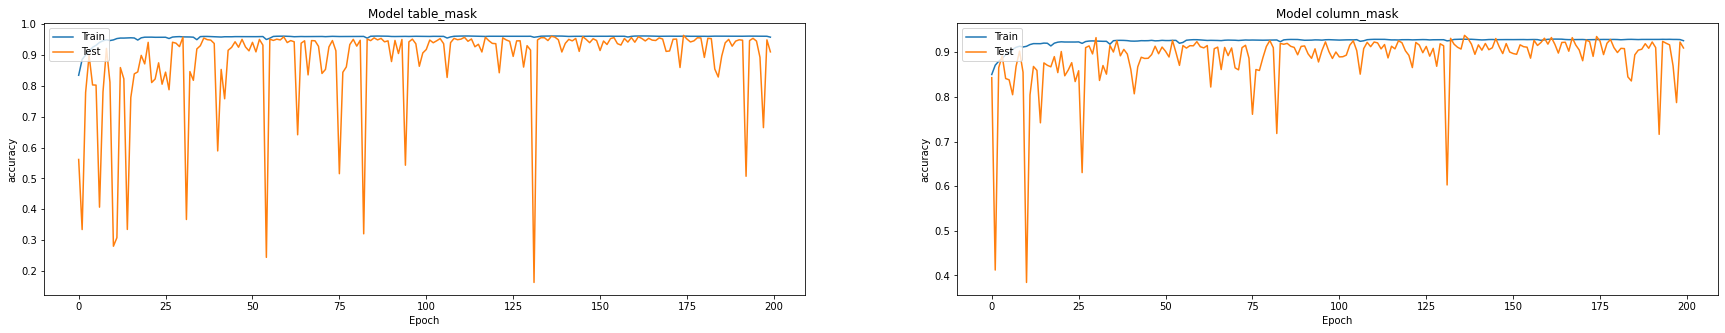

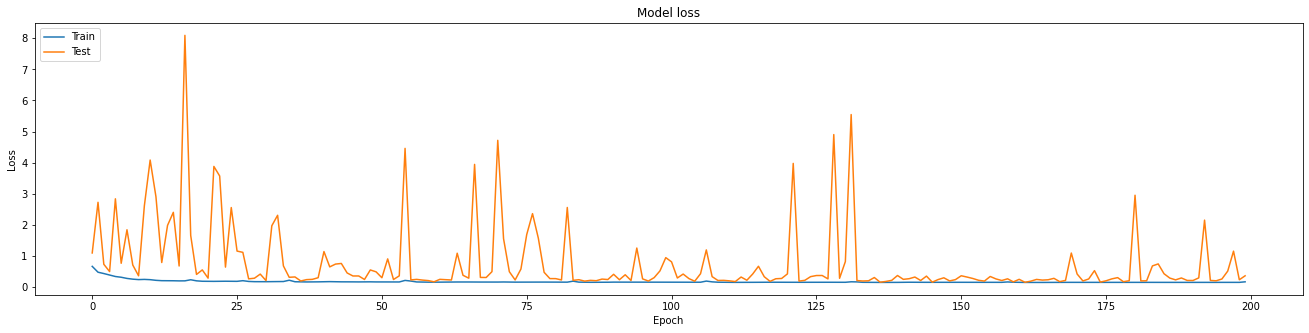

In [14]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model_history.history['table_mask_accuracy'])
plt.plot(model_history.history['val_table_mask_accuracy'])
plt.title('Model table_mask ')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model_history.history['column_mask_accuracy'])
plt.plot(model_history.history['val_column_mask_accuracy'])
plt.title('Model column_mask')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(50, 5))
plt.subplot(122)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [16]:
from keras.models import load_model
model = load_model('mymodel_162')

In [17]:
def masks(table_mask, column_mask):
  table_mask = tf.argmax(table_mask, axis=-1)
  table_mask = table_mask[..., tf.newaxis]


  column_mask = tf.argmax(column_mask, axis=-1)
  column_mask = column_mask[..., tf.newaxis]
  return table_mask[0], column_mask[0]

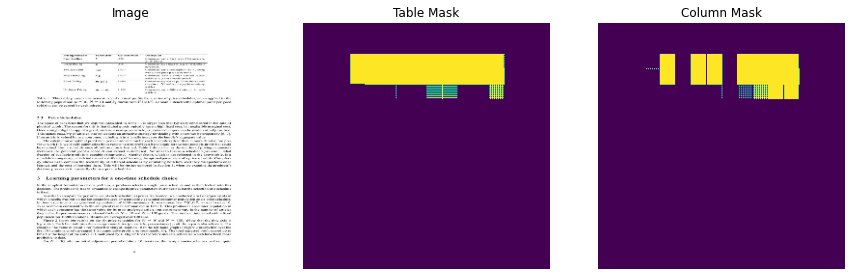

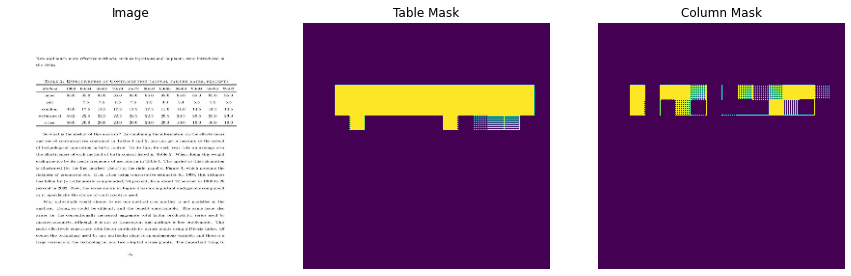

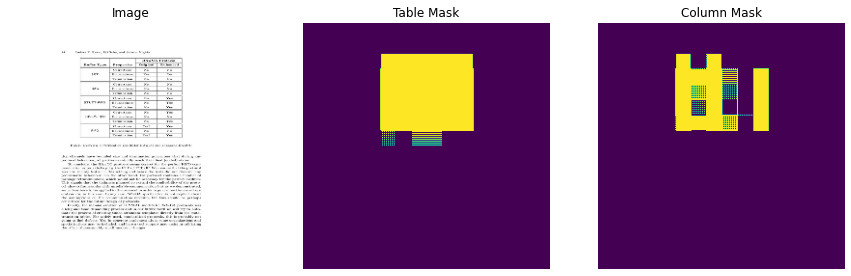

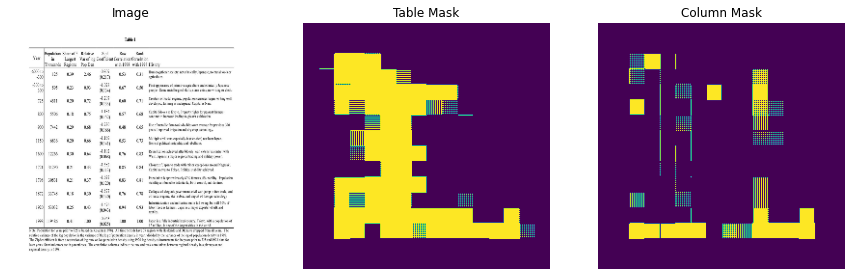

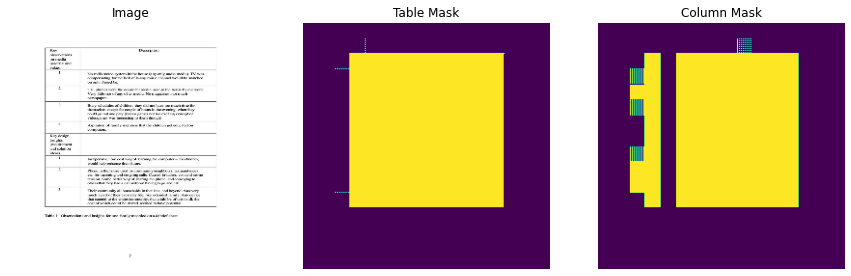

In [19]:
import numpy as np
number = 5
for image, mask  in test_data.take(number):
  plt.figure(figsize=(15, 15))
  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  lists = [image, table_mask, column_mask]
  title = ['Image', 'Table Mask', 'Column Mask']         
  for i in range(len(lists)):
    plt.subplot(1, len(lists), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(lists[i]))
    plt.axis('off')
  plt.show()  

# **Performance validated by Precision , Recall and F1-score**

In [20]:
import numpy as np
table , column = list() , list()
predicted_table , predicted_column = list() , list()
for image, mask  in test_data:
  table.append(mask['table_mask'])
  column.append(mask['column_mask'])
  mask1_, mask2_ = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1_, mask2_)
  predicted_table.append(table_mask)
  predicted_column.append(column_mask)

In [21]:
#https://www.tensorflow.org/api_docs/python/tf/keras/metrics
def recall(table, predicted_table):
  m = tf.keras.metrics.Recall()
  m.update_state(table, predicted_table)
  return m.result().numpy()

def precision(table, predicted_table):
  m = tf.keras.metrics.Precision()
  m.update_state(table, predicted_table)
  return m.result().numpy()  

def result(true , pred):
  Recall = recall(true, pred)
  Precision = precision(true, pred)
  f1 = 2*(Recall * Precision)/(Recall + Precision)
  print(f'Recall is {Recall}')
  print("-"*50)
  print(f'Precision is {Precision}')
  print("-"*50)
  print(f'f1_score is {f1}')

In [22]:
#checking for table mask
result(table , predicted_table)

Recall is 0.8601633310317993
--------------------------------------------------
Precision is 0.9502527117729187
--------------------------------------------------
f1_score is 0.9029665757328534


In [23]:
#checking for column mask
result(column , predicted_column)

Recall is 0.6192747950553894
--------------------------------------------------
Precision is 0.9003177881240845
--------------------------------------------------
f1_score is 0.7338073905416267


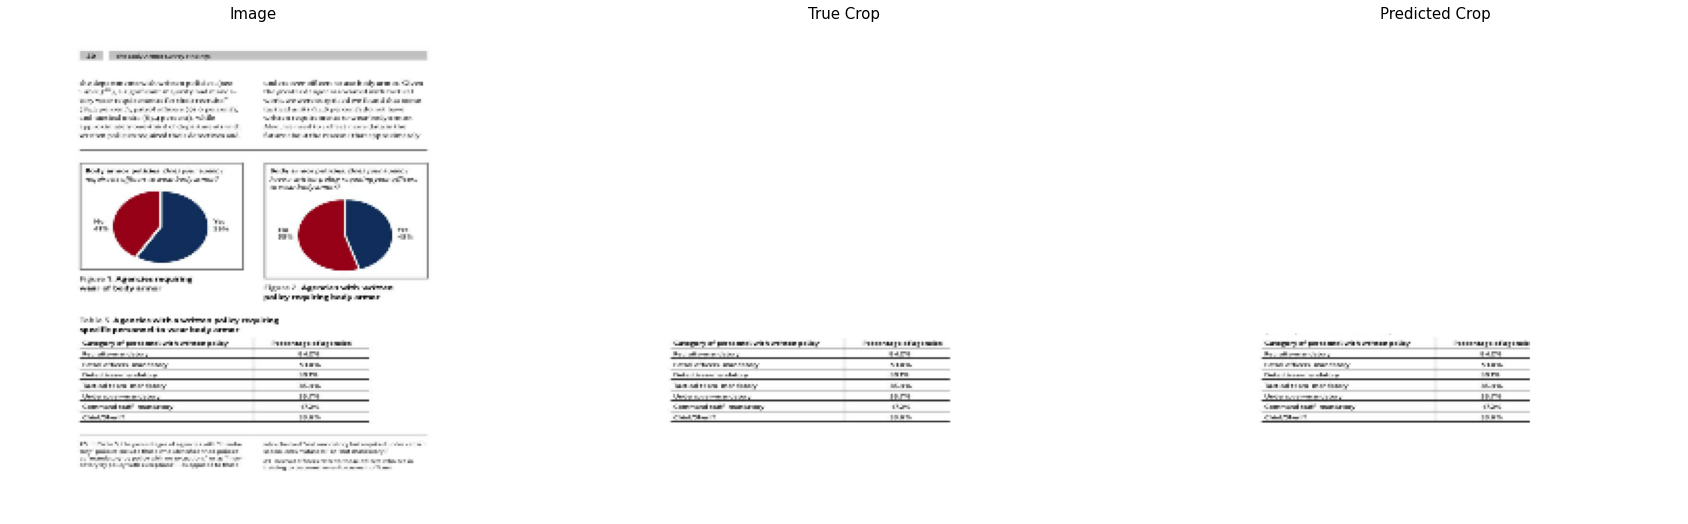

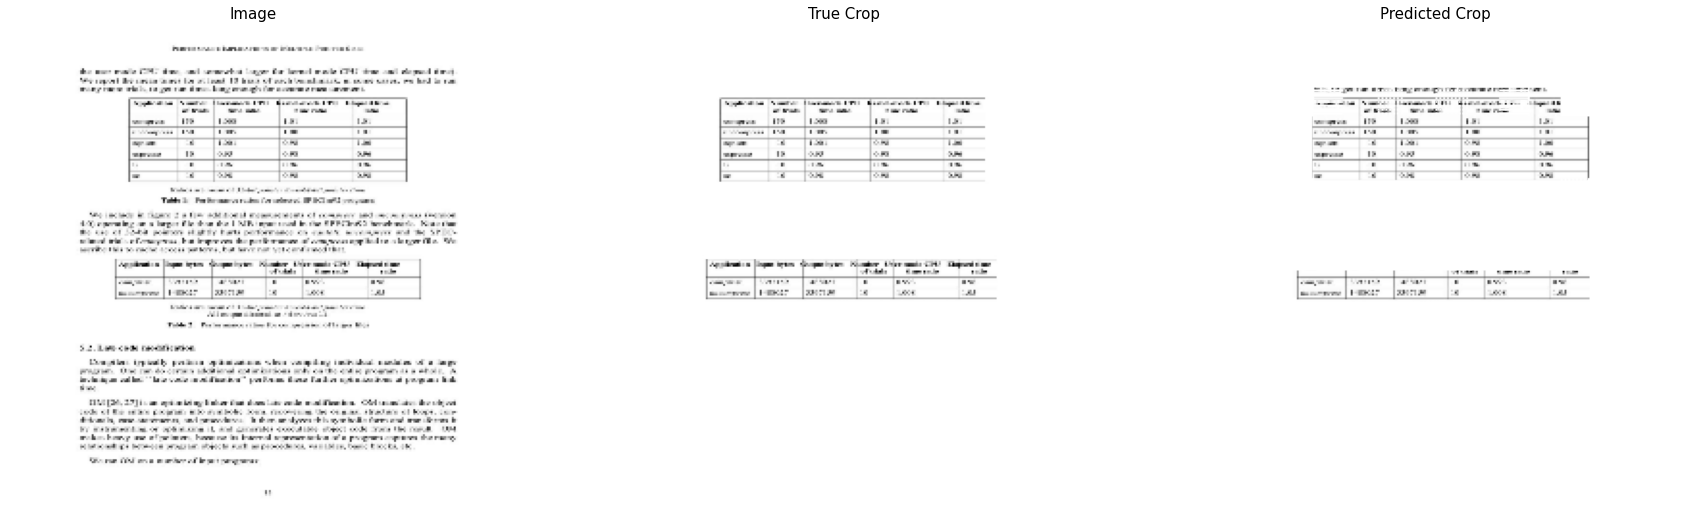

In [28]:
#randomly comparing predicted output with actual output
number = 2
for image, mask  in test_data.take(number):
  plt.figure(figsize=(30, 50))

  true_table = mask['table_mask']
  true_table=tf.keras.preprocessing.image.array_to_img(true_table)
  true_table = true_table.convert('L')

  true_column = mask['column_mask']
  true_column=tf.keras.preprocessing.image.array_to_img(true_column)
  true_column = true_column.convert('L')


  mask1, mask2 = model.predict(image[np.newaxis,:,:,:])
  table_mask, column_mask = masks(mask1, mask2)

  pred_table = tf.keras.preprocessing.image.array_to_img(table_mask)
  pred_column = tf.keras.preprocessing.image.array_to_img(column_mask)
  pred_table = pred_table.convert('L')
  pred_column = pred_column.convert('L')


  title = ['Image', 'True Crop', 'Predicted Crop']         
  for i in range(len(title)): 
    plt.subplot(1, len(title), i+1)
    if i == 0:
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(image))
      plt.axis('off')

    elif i == 1:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(true_table)
      #img.putalpha(true_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))
      plt.axis('off')

    else:
      img = tf.keras.preprocessing.image.array_to_img(image)
      img.putalpha(pred_table)
      #img.putalpha(pred_column)
      plt.title(title[i],fontsize=15)
      plt.imshow(tf.keras.preprocessing.image.array_to_img(img))  
      plt.axis('off')
  plt.show() 

In [39]:
#converting marmot image from .bmp to .jpeg file 
file1 = []
for file in os.listdir('/content/content/MyDrive/table_extraction/top'):
  if file.endswith('.bmp'):
    file1.append(file[:-4])


dir_path = '/content/content/MyDrive/table_extraction/marmots_usuals/'
count=0
for filename in os.listdir(dir_path):  
  if filename.endswith('.jpeg'):
    if filename[:-5] in file1[0:5]:
      count=count+1
      path='/content/content/MyDrive/table_extraction/marmots_usuals/'+filename
      images = tf.io.read_file(path)
      images = tf.image.decode_jpeg(images, channels=3)
      images = tf.image.resize(images, [256, 256])  #Decode a JPEG-encoded image to a uint8 tensor
      images = tf.cast(images, tf.float32) / 255.0 # normalizing image

      mask1, mask2 = model.predict(images[np.newaxis,:,:,:])
      table_mask, column_mask = masks(mask1, mask2)

      im1=tf.keras.preprocessing.image.array_to_img(images)
      im1.save('/content/content/MyDrive/table_extraction/img/image2.bmp')
        
      im2=tf.keras.preprocessing.image.array_to_img(table_mask)
      im2.save('/content/content/MyDrive/table_extraction/table_mas/table_mask2.bmp')
        
      im3=tf.keras.preprocessing.image.array_to_img(column_mask)
      im3.save('/content/content/MyDrive/table_extraction/column_mas/column_mask2.bmp')

      image1  = Image.open(path)
      image1=image1.resize((1024,1024),Image.ANTIALIAS)
      image1.save('/content/content/MyDrive/table_extraction/img/image2.bmp')

      image2 = Image.open('/content/content/MyDrive/table_extraction/table_mas/table_mask2.bmp')
      image2=image2.resize((1024,1024),Image.ANTIALIAS)
      image2.save('/content/content/MyDrive/table_extraction/table_mas/table_mask2.bmp')

      img_org  = Image.open('/content/content/MyDrive/table_extraction/img/image2.bmp')
      img_mask = Image.open('/content/content/MyDrive/table_extraction/table_mas/table_mask2.bmp')
      img_mask_column = Image.open('/content/content/MyDrive/table_extraction/column_mas/column_mask2.bmp')

      # convert images
      #img_org  = img_org.convert('RGB') # or 'RGBA'
      img_mask = img_mask.convert('L')    # grayscale


      # add alpha channel    
      img_org.putalpha(img_mask)
      #img_org.putalpha(img_mask_column)

      # save as png which keeps alpha channel 
      img_org.save('/content/content/MyDrive/table_extraction/exp/' + filename[:-5] + '.png' )

# Example 1

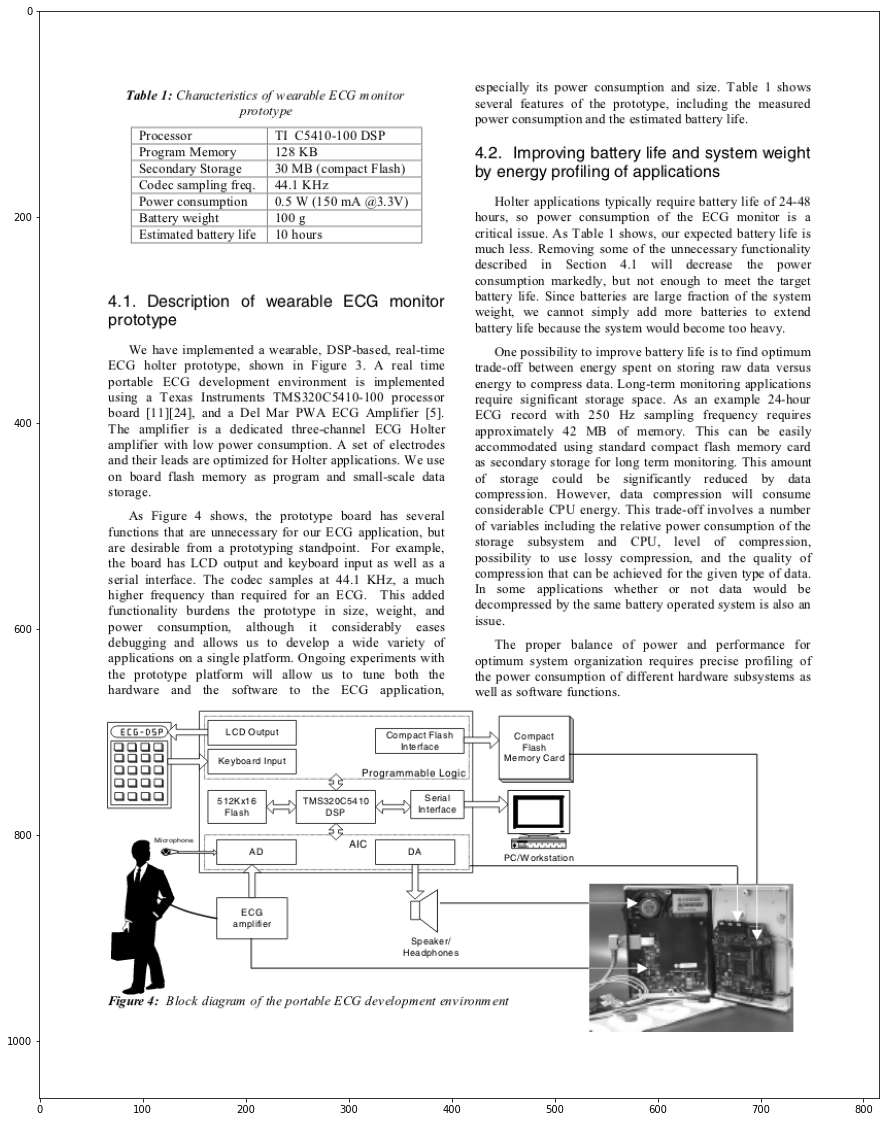

In [48]:
#showing orignal image
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/top/10.1.1.33.5766_4.bmp')
imgplot = plt.imshow(img)
plt.show()

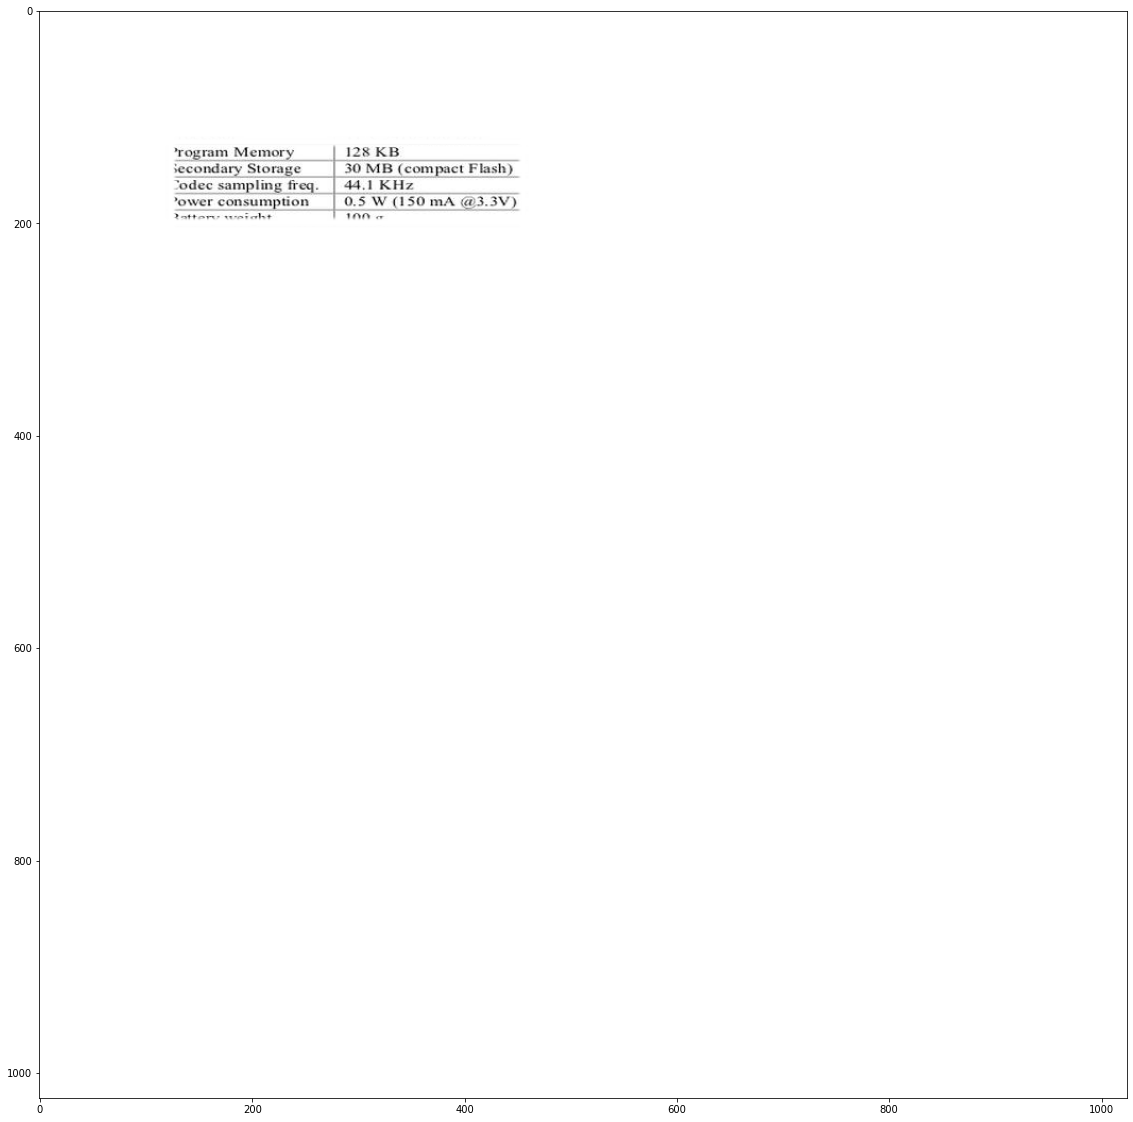

In [50]:
##showing predicted table
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/exp/10.1.1.33.5766_4.png')
imgplot = plt.imshow(img)
plt.show()

# Example 2

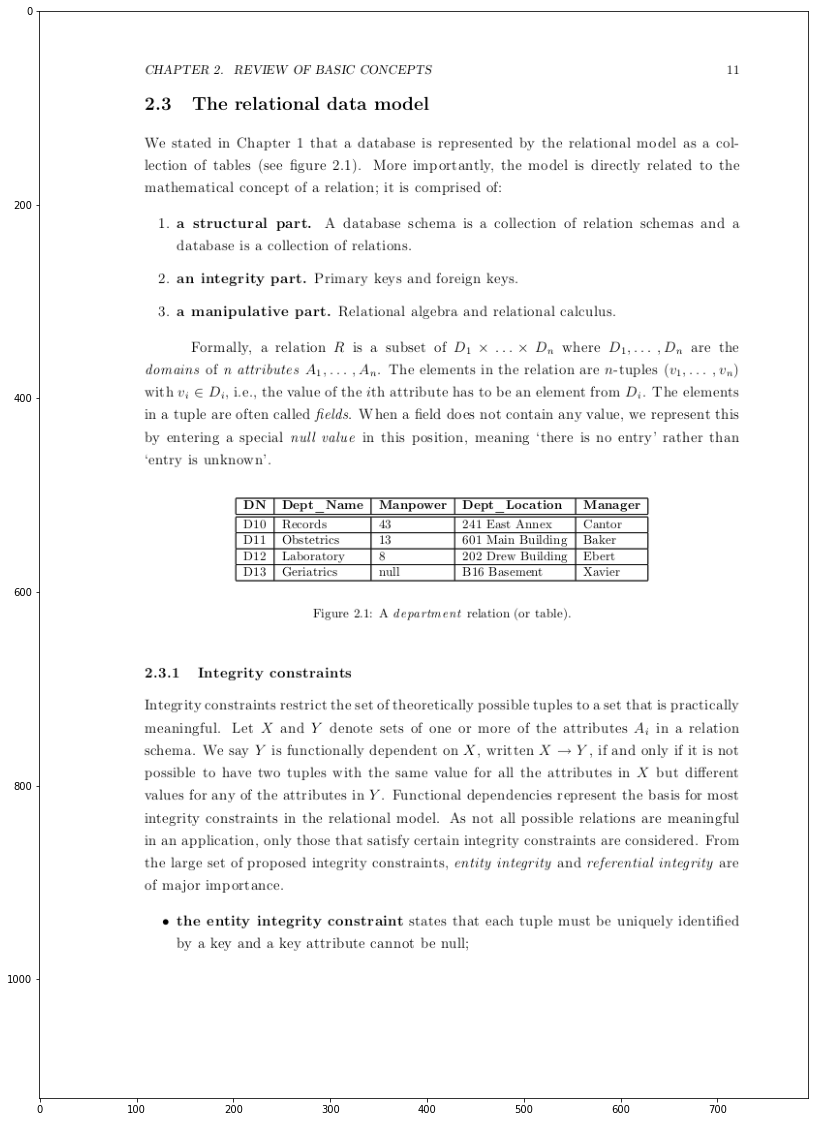

In [47]:
#showing orignal image
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/top/10.1.1.1.2031_24.bmp')
imgplot = plt.imshow(img)
plt.show()

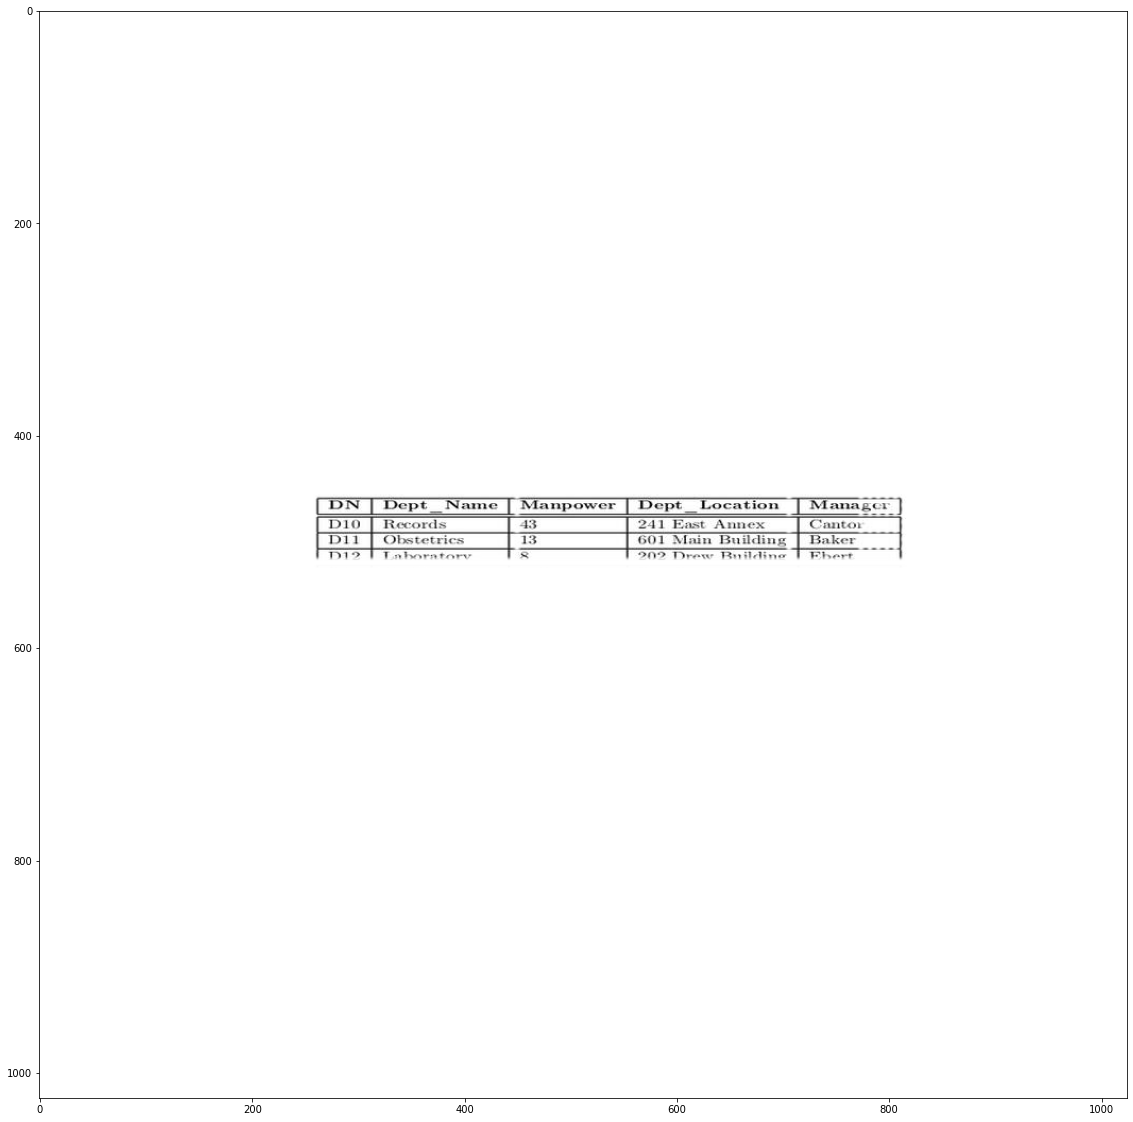

In [51]:
##showing predicted table
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/exp/10.1.1.1.2031_24.png')
imgplot = plt.imshow(img)
plt.show()

# Example 3

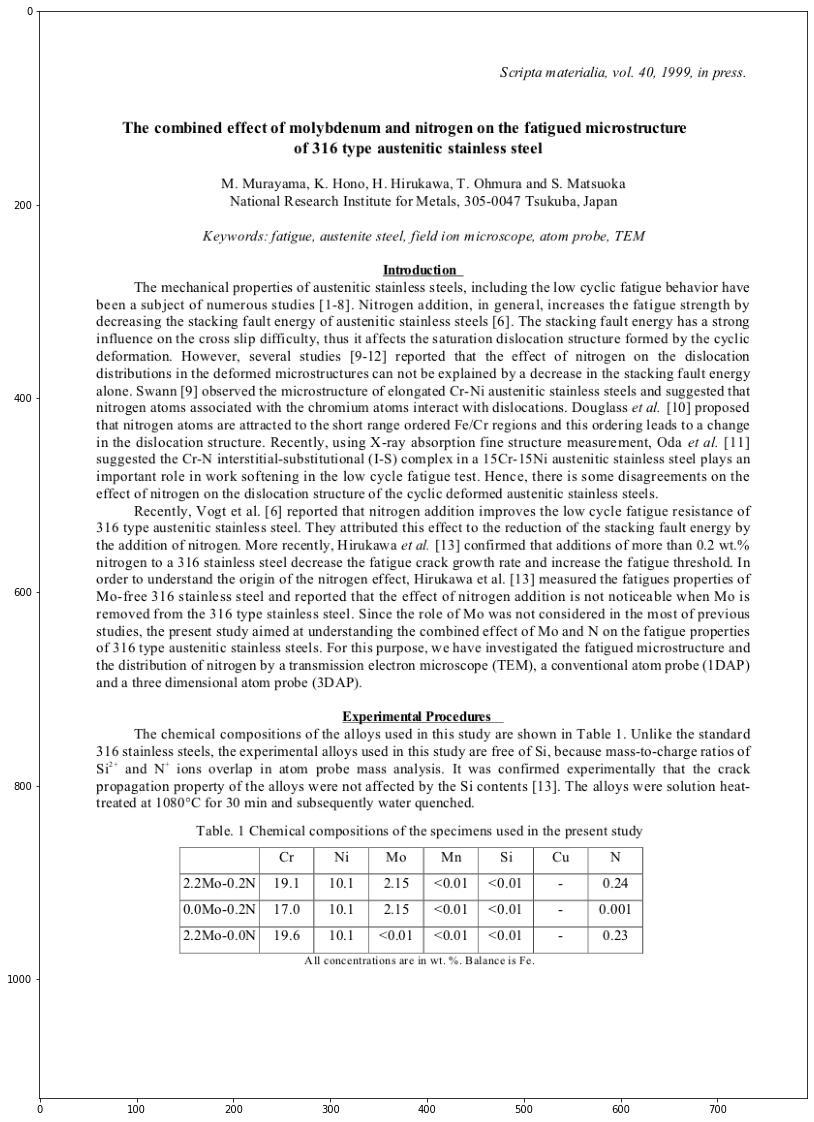

In [46]:
#showing orignal image
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/top/10.1.1.34.3054_1.bmp')
imgplot = plt.imshow(img)
plt.show()

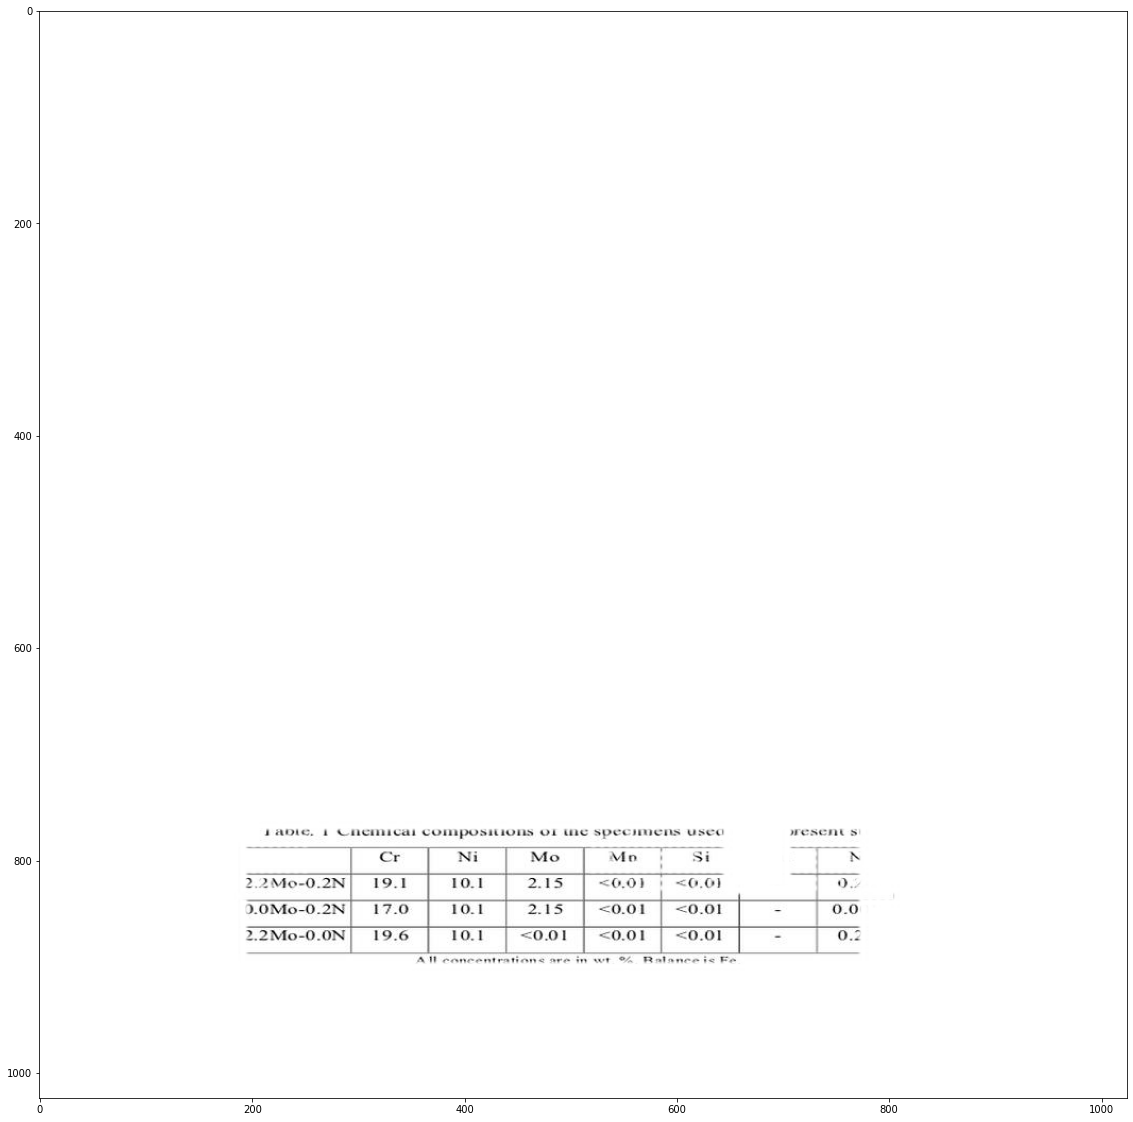

In [52]:
##showing predicted table
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/exp/10.1.1.34.3054_1.png')
imgplot = plt.imshow(img)
plt.show()

# Example 4

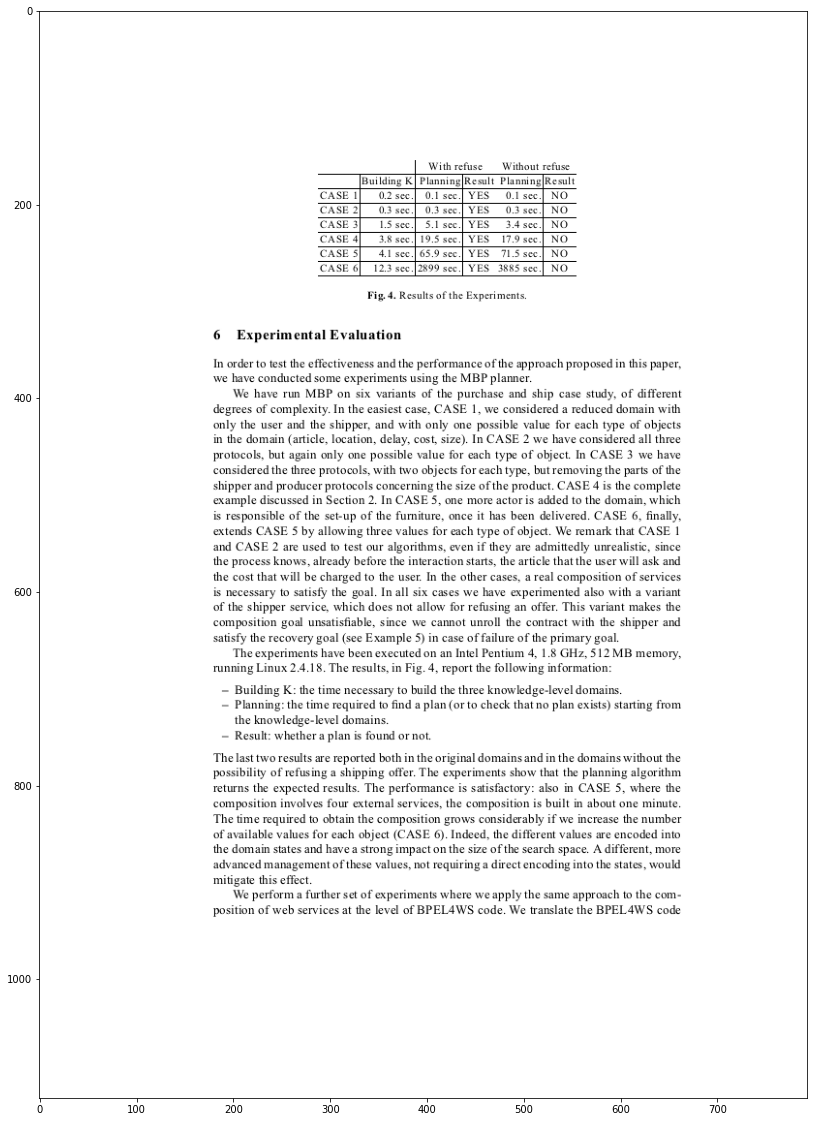

In [45]:
#showing orignal image
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/top/10.1.1.1.2100_12.bmp')
imgplot = plt.imshow(img)
plt.show()

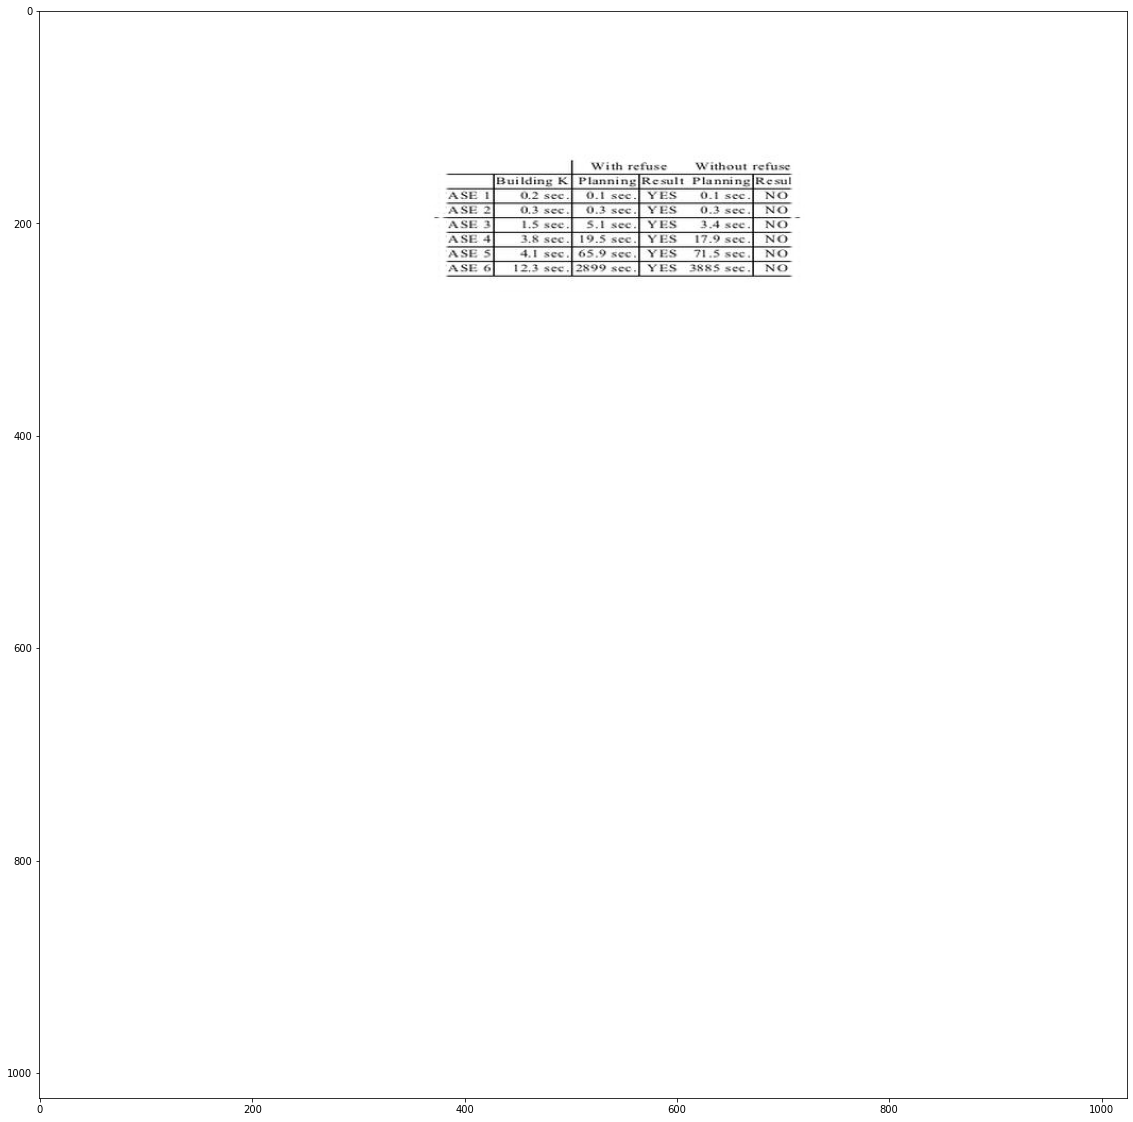

In [53]:
##showing predicted table
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/exp/10.1.1.1.2100_12.png')
imgplot = plt.imshow(img)
plt.show()

# Example 5

Populating the interactive namespace from numpy and matplotlib


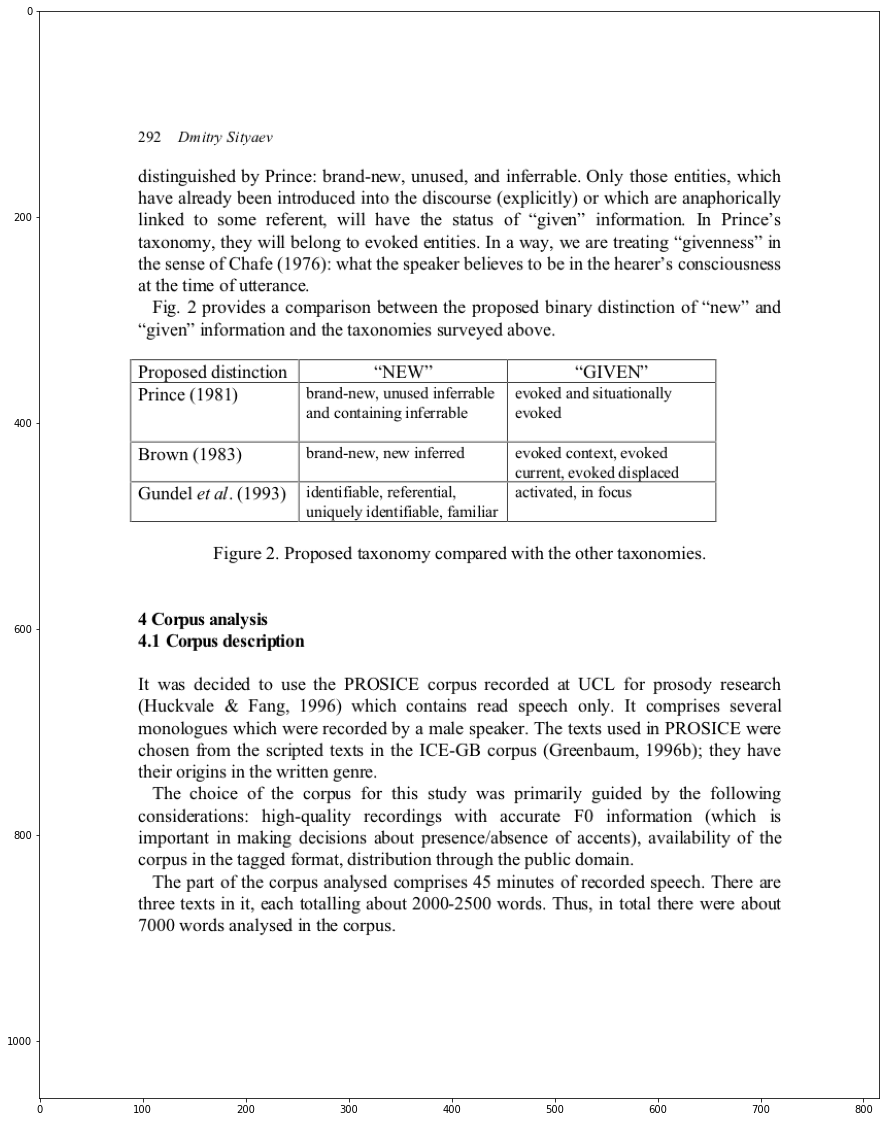

In [44]:
#showing orignal image
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/top/10.1.1.100.2031_8.bmp')
imgplot = plt.imshow(img)
plt.show()

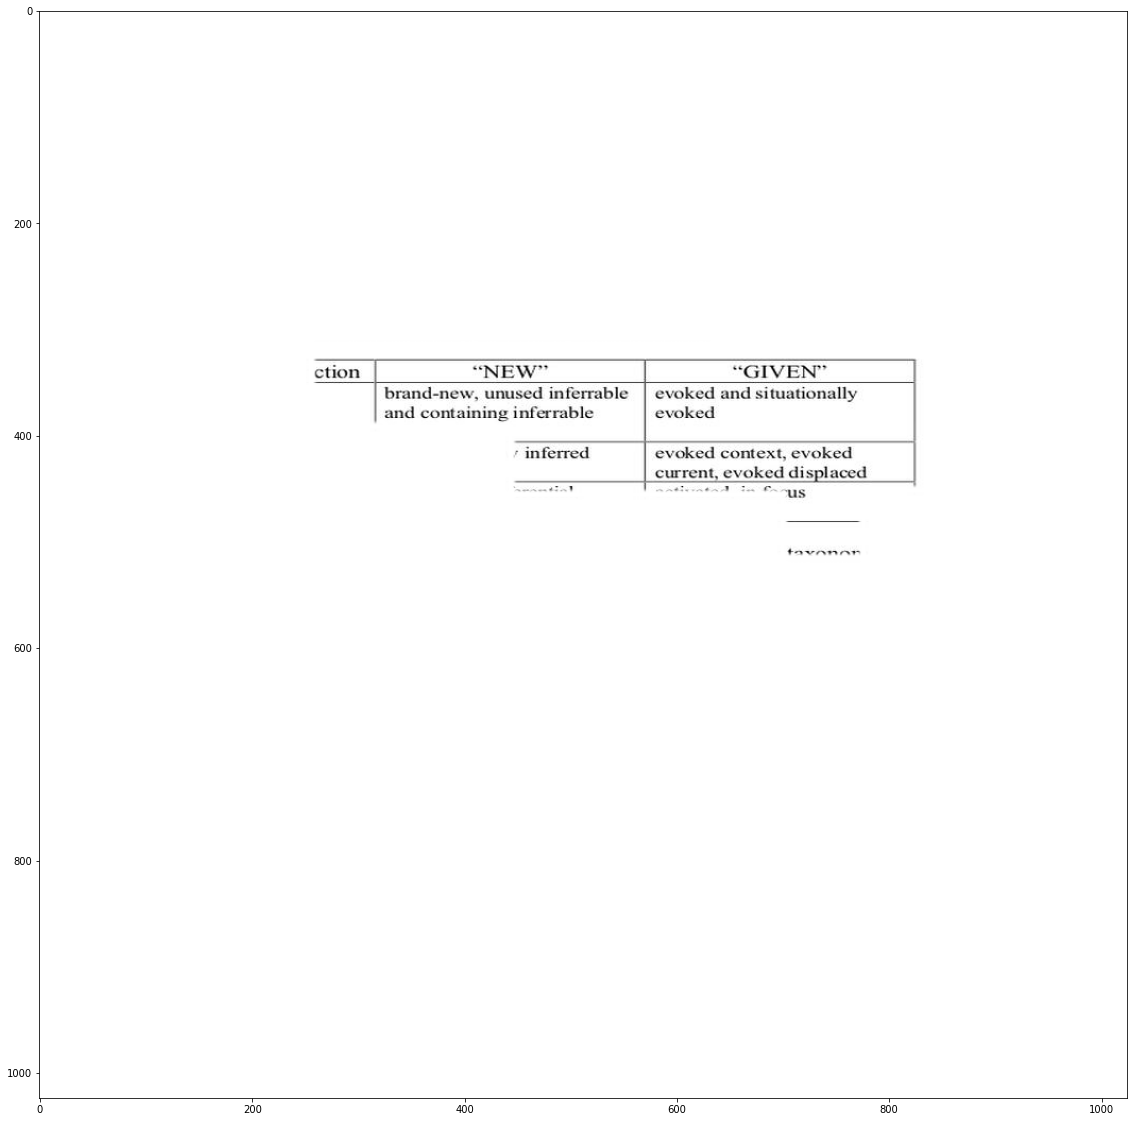

In [54]:
##showing predicted table
plt.figure(figsize=(50,20))
img = mpimg.imread('/content/content/MyDrive/table_extraction/exp/10.1.1.100.2031_8.png')
imgplot = plt.imshow(img)
plt.show()

# Conclusion:
1. i have tried AlexNet encoder arcitecture and merge with decoder to predict table and column mask.
2. The coessponding Precision , recall and f1-score for AlexNet is not improved than TableNet .
3. The validation loss is more as comapare to TableNet.